In [1]:
### Loading required modules

import numpy as np
import tensorflow as tf
import os,sys
import datetime
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Activation, Dense
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import cv2
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

tf.config.list_physical_devices('GPU')

path="/home/ubuntu/pediatric_dental_age_prediction/mask/"

#whichMask = "predMask"   ### Probability mask (0.05, 0.61, 0.97)
whichMask = "predMask_bin"  ### Binarized mask (0, 1, 1)

print("Loaded all modules")

2023-11-12 20:25:57.098086: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-12 20:25:57.750970: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loaded all modules


2023-11-12 20:25:59.191295: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-12 20:25:59.214579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-12 20:25:59.216583: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
### Prep for training data (8 GB RAM used for 1400 images)

X_train_li = [] ### arrays of inferred-mask images
Y_train_li = [] ### ages of corresponding images
subj_train_li = []
fn_train_li = []

trainAgeDic={}
with open(path+"train_age.txt") as ageFile:
    for line in ageFile.readlines():
        subj, corrAgeStr = line.rstrip().split("\t")
        trainAgeDic[subj] = float(corrAgeStr)

for imgFn in os.listdir(path+"train_"+whichMask):
    cvImgNorm = cv2.imread(path+"train_{0}/".format(whichMask)+imgFn)/255
    subj = "_".join(imgFn.split("_")[:2])
    cvImgAge = trainAgeDic[subj]

    X_train_li.append(cvImgNorm)
    Y_train_li.append(cvImgAge)
    subj_train_li.append(subj)
    fn_train_li.append(imgFn)

X_train = np.array(X_train_li)
Y_train = np.array(Y_train_li)
print("Prep for train set done")

Prep for train set done


In [3]:
### Prep for testing data (1.9 GB RAM used for 300 images)

X_test_li = [] ### arrays of inferred-mask images
Y_test_li = [] ### ages of corresponding images
subj_test_li = []
fn_test_li = []

testAgeDic={}
with open(path+"test_age.txt") as ageFile:
    for line in ageFile.readlines():
        subj, corrAgeStr = line.rstrip().split("\t")
        testAgeDic[subj] = float(corrAgeStr)

for imgFn in os.listdir(path+"test_"+whichMask):
    cvImgNorm = cv2.imread(path+"test_{0}/".format(whichMask)+imgFn)/255
    subj = "_".join(imgFn.split("_")[:2])
    cvImgAge = testAgeDic[subj]

    X_test_li.append(cvImgNorm)
    Y_test_li.append(cvImgAge)
    subj_test_li.append(subj)
    fn_test_li.append(imgFn)

X_test = np.array(X_test_li)
Y_test = np.array(Y_test_li)
print("Prep for test set done")

Prep for test set done


In [4]:
### Defining CNN+FCL regression model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Activation, Dense
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

def createCNN(inputShape,
              cnnFilterNumbersGiven,
              fclFilterNumbersGiven,
              cnnDropoutRateGiven,
              fclDropoutRateGiven,
              cnnBatchNormBoolGiven,
              fclBatchNormBoolGiven,
              cnnActivationFunctionGiven,
              fclActivationFunctionGiven):
    chanDim = -1

    #### CNN layer

    model = Sequential()
    
    for (i,f) in enumerate(cnnFilterNumbersGiven):
        # CONV => RELU => BN => POOL => DropOut
        if i == 0:
            model.add(Conv2D(f, (3, 3), padding="same",
                   activation=cnnActivationFunctionGiven,
                            input_shape = inputShape))
        else:
            model.add(Conv2D(f, (3, 3), padding="same",
                   activation=cnnActivationFunctionGiven))
        if cnnBatchNormBoolGiven:
            model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        if cnnDropoutRateGiven!=0:
            model.add(Dropout(cnnDropoutRateGiven))
    
    model.add(Flatten())

    #### FC Layer
    for f in fclFilterNumbersGiven:
        model.add(Dense(f, activation=fclActivationFunctionGiven))
        if fclBatchNormBoolGiven:
            model.add(BatchNormalization(axis=chanDim))
        if fclDropoutRateGiven != 0:
            model.add(Dropout(fclDropoutRateGiven))
    
    model.add(Dense(1, activation = "linear"))

    print("CNN+FCL model built with tensorflow.keras")
    
    return(model)

In [5]:
### Defining CNN+FCL models with parameters

## Model part
cnnFilterNumbers = [4, 8, 16, 32, 64]
cnnDropoutRate = 0.25
cnnBatchNormBool = True
cnnActivationFunction = "relu"

fclFilterNumbers = [16]
fclDropoutRate = 0.5
fclBatchNormBool = True 
fclActivationFunction = "relu"



## Learning part

lossFunction = "mean_squared_error"

learningRate = 1e-3
epochSize = 200
batchSize = 8

optimizer = "Adam"

def optimizer_select(optimizer, learningRate
              ):
    
    if optimizer == "Adam":
        opt = Adam(learning_rate=learningRate)
    elif optimizer == "RMSprop":
        opt = RMSprop(learning_rate=learningRate)
    elif optimizer == "SGD":
        opt = SGD(learning_rate=learningRate)
    
    return(opt)


model = createCNN(inputShape = X_train.shape[1:],
                  cnnFilterNumbersGiven = cnnFilterNumbers,
                  fclFilterNumbersGiven = fclFilterNumbers,
                  cnnDropoutRateGiven = cnnDropoutRate,
                  fclDropoutRateGiven = fclDropoutRate,
                  cnnBatchNormBoolGiven = cnnBatchNormBool,
                  fclBatchNormBoolGiven = fclBatchNormBool,
                  cnnActivationFunctionGiven = cnnActivationFunction,
                  fclActivationFunctionGiven = fclActivationFunction)

model.compile(loss=lossFunction, optimizer = optimizer_select(optimizer, learningRate))

2023-11-12 20:26:20.639156: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-12 20:26:20.641443: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-12 20:26:20.643357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

CNN+FCL model built with tensorflow.keras


In [6]:
### Training the model

print("Training the model...")

modelHistory = model.fit(x=X_train, y=Y_train,
                    validation_data = (X_test, Y_test),
    epochs=epochSize, batch_size=batchSize, verbose = 1)


Training the model...


2023-11-12 20:26:26.363651: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2202009600 exceeds 10% of free system memory.
2023-11-12 20:26:27.351111: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2202009600 exceeds 10% of free system memory.


Epoch 1/200


2023-11-12 20:26:29.335699: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-12 20:26:30.347750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8903
2023-11-12 20:26:30.993992: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-12 20:26:30.995593: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7efcb5be0d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-12 20:26:30.995617: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2023-11-12 20:26:30.999651: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] di

175/175 [==============================] - 8s 15ms/step - loss: 53.6733 - val_loss: 14.1854
Epoch 2/200
175/175 [==============================] - 2s 10ms/step - loss: 34.9744 - val_loss: 7.3644
Epoch 3/200
175/175 [==============================] - 2s 10ms/step - loss: 16.0443 - val_loss: 13.1333
Epoch 4/200
175/175 [==============================] - 2s 10ms/step - loss: 7.8901 - val_loss: 28.8569
Epoch 5/200
175/175 [==============================] - 2s 10ms/step - loss: 6.3580 - val_loss: 3.1301
Epoch 6/200
175/175 [==============================] - 2s 10ms/step - loss: 6.1668 - val_loss: 3.5731
Epoch 7/200
175/175 [==============================] - 2s 10ms/step - loss: 6.0589 - val_loss: 2.5841
Epoch 8/200
175/175 [==============================] - 2s 10ms/step - loss: 5.6974 - val_loss: 2.4198
Epoch 9/200
175/175 [==============================] - 2s 10ms/step - loss: 5.4332 - val_loss: 1.8161
Epoch 10/200
175/175 [==============================] - 2s 10ms/step - loss: 5.7562 - va

In [7]:
### Saving the model

import datetime
import pickle

lossFxShort = "".join([x[0] for x in lossFunction.split("_")])
modelTime = (datetime.datetime.now() + datetime.timedelta(hours=9)).strftime('%m%d_%H%M')

modelName = path+"model/cnn-fcl-direct.{0}.loss_{1}.lr_{2}.optimizer_{3}.epoch_{4}.batch_{5}.\
conv-{6}_dropout-{7}_bn-{8}_actFx-{9}.\
fcl-{10}_dropout-{11}_bn-{12}_actFx-{13}.time_{14}.keras".format(whichMask, lossFxShort,
                                                                learningRate,
                                                                optimizer,
                                                                epochSize,
                                                                batchSize,
                                                                "-".join([str(k) for k in cnnFilterNumbers]),
                                                                cnnDropoutRate,
                                                                cnnBatchNormBool,
                                                                cnnActivationFunction,
                                                                "-".join([str(k) for k in fclFilterNumbers]),
                                                                fclDropoutRate,
                                                                fclBatchNormBool,
                                                                fclActivationFunction,
                                                                modelTime)

modelHistoryName = path+"modelHistory/cnn-fcl-direct.{0}.loss_{1}.lr_{2}.optimizer_{3}.epoch_{4}.batch_{5}.\
conv-{6}_dropout-{7}_bn-{8}_actFx-{9}.\
fcl-{10}_dropout-{11}_bn-{12}_actFx-{13}.time_{14}.history".format(whichMask, lossFxShort,
                                                                  learningRate,
                                                                  optimizer,
                                                                  epochSize,
                                                                  batchSize,
                                                                  "-".join([str(k) for k in cnnFilterNumbers]),
                                                                  cnnDropoutRate,
                                                                  cnnBatchNormBool,
                                                                  cnnActivationFunction,
                                                                  "-".join([str(k) for k in fclFilterNumbers]),
                                                                  fclDropoutRate,
                                                                  fclBatchNormBool,
                                                                  fclActivationFunction,
                                                                  modelTime)
model.save(modelName)

with open(modelHistoryName, 'wb') as file_pi:
        pickle.dump(modelHistory, file_pi)

print("Model fully trained and saved")

Model fully trained and saved


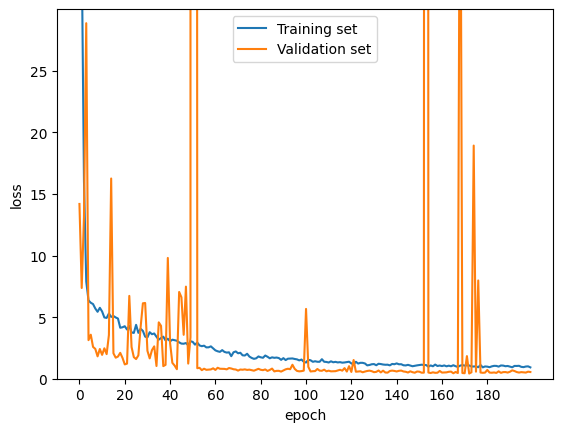

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 512, 4)       112       
                                                                 
 batch_normalization (Batch  (None, 256, 512, 4)       16        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 256, 4)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 256, 4)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 256, 8)       296       
                                                                 
 batch_normalization_1 (Bat  (None, 128, 256, 8)       3

In [8]:
### Model learning curve and summary

from matplotlib import pyplot as plt

ylimLoss = 30

plt.plot(modelHistory.history['loss'], label = "Training set")
plt.plot(modelHistory.history['val_loss'], label = "Validation set")
plt.xlabel('epoch')
plt.ylabel('loss')

plt.xticks(np.arange(0,epochSize, 20))
plt.yticks(np.arange(0,ylimLoss, 5))
plt.ylim(bottom=0, top=ylimLoss)
plt.legend()

plt.show()

model.summary()

In [9]:
### Computing evalutation metrics

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

evalDic={}
evalDicName = path+"eval/cnn-fcl-direct.{0}.loss_{1}.lr_{2}.optimizer_{3}.epoch_{4}.batch_{5}.\
conv-{6}_dropout-{7}_bn-{8}_actFx-{9}.\
fcl-{10}_dropout-{11}_bn-{12}_actFx-{13}.time_{14}.eval".format(whichMask, lossFxShort,
                                                               learningRate,
                                                               optimizer,
                                                               epochSize,
                                                               batchSize,
                                                               "-".join([str(k) for k in cnnFilterNumbers]),
                                                               cnnDropoutRate,
                                                               cnnBatchNormBool,
                                                               cnnActivationFunction,
                                                               "-".join([str(k) for k in fclFilterNumbers]),
                                                               fclDropoutRate,
                                                               fclBatchNormBool,
                                                               fclActivationFunction,
                                                               modelTime)

Y_pred = model.predict(X_test)
Y_gold = Y_test.reshape(-1,1)

mse_val = mean_squared_error(Y_gold, Y_pred)
rmse_val = mean_squared_error(Y_gold, Y_pred, squared=False)
mae_val = mean_absolute_error(Y_gold, Y_pred)
mape_val = mean_absolute_percentage_error(Y_gold, Y_pred)
r2_val = r2_score(Y_gold, Y_pred)

evalDic["subj"]=np.array(subj_test_li).reshape(-1, 1)
evalDic["pred"]=Y_pred
evalDic["gold"]=Y_gold

evalDic["mse"]=mse_val
evalDic["rmse"]=rmse_val
evalDic["mae"]=mae_val
evalDic["mape"]=mape_val
evalDic["r2"]=r2_val

with open(evalDicName, 'wb') as file_pi:
        pickle.dump(evalDic, file_pi)
    
print("Evaluation done")

10/10 [==============================] - 0s 20ms/step
Evaluation done


Mean-squared error: 0.544803754434046
Mean absolute error: 0.6197375440597535
Mean absolute percentage error: 0.10017640170485304
R2: 0.7307394953373743


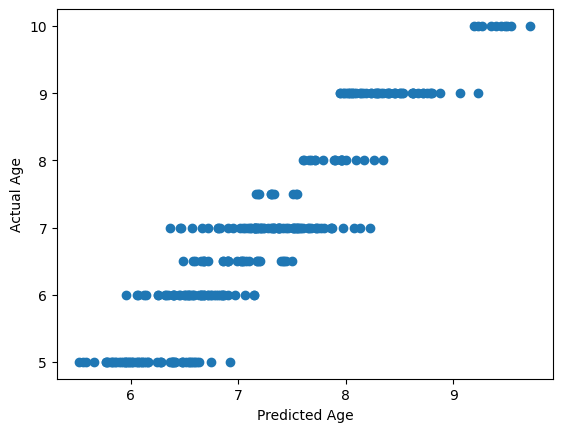

In [10]:
### Quick visualization of evaluation metrics

from matplotlib import pyplot as plt

print("Mean-squared error: {0}".format(evalDic["mse"]))
print("Root mean-squared error: {0}".format(evalDic["rmse"]))

print("Mean absolute error: {0}".format(evalDic["mae"]))
print("Mean absolute percentage error: {0}".format(evalDic["mape"]))
print("R2: {0}".format(evalDic["r2"]))

plt.scatter(evalDic["pred"], evalDic["gold"])
plt.xlabel("Predicted Age")
plt.ylabel("Actual Age")
plt.show()

In [ ]:
-